<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/GCA-Net/gca_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 6.7MB/s 


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import *
from tensorflow.keras import backend as K
import math
from tensorflow_addons.layers import InstanceNormalization

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352 , 1216), antialias = True)
    img = img / 255.0
    return img

In [5]:
def dataset_preposses(orig_img_path='/content/drive/MyDrive/generated_dataset/trans',hazy_img_path='/content/drive/MyDrive/generated_dataset/hazy',percentage=0.1,validation_size=200,test_size=64,seed_val=200):
    train_img = []
    val_img = []
    random.seed=seed_val
    orig_img = glob.glob(orig_img_path + '/*.png')
    n = len(orig_img)
    random.shuffle(orig_img)
    red_keys=orig_img[:]                                 #redundant keys to avoid key error
    train_keys = orig_img[:int(0.9*n*percentage)]
    #print(0.9*n*percentage)
    #print(len(train_keys))
    val_keys = orig_img[-int(0.1*n*percentage):]
    #print(len(val_keys))
    split_dict = {}
    #i=0
    for key in red_keys:
      split_dict[key]='red'
      #i+=1
    #print(i)
    for key in train_keys:
      split_dict[key] = 'train'
    for key in val_keys:
      split_dict[key] = 'val'
      
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    for img in hazy_img:
      
      img_name = img.split('/')[-1][:-4].split('_')[0]
      orig_path = orig_img_path + '/' + img_name+'.png'
      if (split_dict[orig_path] == 'train'):
        train_img.append([img, orig_path])
      if (split_dict[orig_path] == 'val'):
        val_img.append([img, orig_path])
      

    return train_img, val_img


def gen_dataset(ar):
  '''
  parameters
  list of paths
  return
  list with gt attached 
  '''
  orig_path='/content/drive/MyDrive/kitti/gt'
  haze_pth='/content/drive/MyDrive/kitti/hazy'
  lst=[]
  for i in ar:
    name=i.split('/')[-1].split('_')[0]
    pthlist=[i,orig_path+'/'+name+'.jpg']
    lst.append(pthlist)
  return lst

def data_path(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy'):
  
  (a,b,c)=dataset_preposses(orig_path=orig_img_path,haze_path=hazy_img_path)
  a=gen_dataset(a)
  b=gen_dataset(b)
  return a,b

In [6]:
def dataloader(train_data, val_data, batch_size):
    print(len(train_data))
    train_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in train_data]).map(lambda x: load_image(x))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in train_data]).map(lambda x: load_image(x))
    train = tf.data.Dataset.zip((train_data_haze, train_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    val_data_orig = tf.data.Dataset.from_tensor_slices([img[1] for img in val_data]).map(lambda x: load_image(x))
    val_data_haze = tf.data.Dataset.from_tensor_slices([img[0] for img in val_data]).map(lambda x: load_image(x))
    val = tf.data.Dataset.zip((val_data_haze, val_data_orig)).shuffle(buffer_size=100).batch(batch_size)
    
    return train, val

In [7]:
def display_img(model, hazy_img, orig_img):
    
    dehazed_img = model(hazy_img,training = False)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], dehazed_img[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(3, 1, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        directory='/content/drive/MyDrive/Test/padCheck'
        os.chdir(directory)
        filename=str(i)+'.jpg'
        tf.keras.preprocessing.image.save_img(filename,display_list[i],)
        #plt.imsave('plt'+filename,display_list[i])
    plt.show()

## Model


In [36]:
class smoothDilateRes(tf.keras.Model):
  def __init__(self, channel_num, dilation=1, group=1):
        super(smoothDilateRes, self).__init__()
        self.pre_conv1=tf.keras.layers.Conv2D(channel_num,dilation*2-1,1,padding='same',dilation_rate=1,groups=group,use_bias=False)
        self.conv1 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm1 = InstanceNormalization()
        self.act1=tf.keras.layers.ReLU()
        self.pre_conv2=tf.keras.layers.Conv2D(channel_num,dilation*2-1,1,padding='same',dilation_rate=1,groups=group,use_bias=False)
        self.conv2 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm2 = InstanceNormalization()
        self.act2=tf.keras.layers.ReLU()
        
  def call(self, x):

        y=self.conv1(self.pre_conv1(x))
        #y=self.conv1(x)
        y=self.norm1(y)
        y=self.act1(y)
        
        y=self.conv2(self.pre_conv2(y))
        #y=self.conv2(y)
        y=self.norm2(y)
        
        return self.act2(x+y)
        

  
    

class ResBlock(tf.keras.Model):
    def __init__(self, channel_num, dilation=1, group=1):
        super(ResBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm1 = InstanceNormalization()
        self.act1=tf.keras.layers.ReLU()
        self.conv2 = tf.keras.layers.Conv2D(channel_num,3,1,padding='same',dilation_rate=dilation,groups=group,use_bias=False)
        self.norm2 = InstanceNormalization()
        self.act2=tf.keras.layers.ReLU()
        
    def call(self, x):
        y = self.act1(self.norm1(self.conv1(x)))
        y = self.norm1(self.conv2(y))
        return self.act2(x+y)



In [37]:


class GCA(tf.keras.Model):
    def __init__(self, in_c=4, out_c=3, only_residual=True):
        super(GCA, self).__init__()
        #self.relu1= tf.keras.layers.ReLU()
        
        self.conv1 = tf.keras.layers.Conv2D(64,3,strides=1,padding='same',use_bias=False,activation='relu')             
        self.norm1 = InstanceNormalization()
        self.conv2 = tf.keras.layers.Conv2D(64,3,strides=1,padding='same',use_bias=False,activation='relu')
        self.norm2 = InstanceNormalization()
        self.conv3 = tf.keras.layers.Conv2D(64,3,strides=2,padding='same',use_bias=False,activation='relu')
        self.norm3 = InstanceNormalization()
        self.res1 = smoothDilateRes(64, dilation=2)
        self.res2 = smoothDilateRes(64, dilation=2)
        self.res3 = smoothDilateRes(64, dilation=2)
        self.res4 = smoothDilateRes(64, dilation=4)
        self.res5 = smoothDilateRes(64, dilation=4)
        self.res6 = smoothDilateRes(64, dilation=4)
        self.res7 = ResBlock(64, dilation=1)

        self.gate = tf.keras.layers.Conv2D(3,3,1,padding='same',use_bias=True,activation='relu')
        #nn.ConvTranspose2d(64, 64, 4, 2, 1)
        self.deconv3 =tf.keras.layers.Conv2DTranspose(64,4,2,padding='same',activation='relu')
        self.norm4 = InstanceNormalization()
        self.deconv2 =tf.keras.layers.Conv2D(64,3,1,padding='same',activation='relu') 
        self.norm5 = InstanceNormalization()
        #nn.Conv2d(64, 64, 3, 1, 1)
        self.deconv1 =tf.keras.layers.Conv2D(out_c,1,activation='relu')
        self.only_residual = only_residual
        
       
    def call(self, input_tensor, training=False):
       
        y = self.norm1(self.conv1(input_tensor))
        y = self.norm2(self.conv2(y))   
        y1= self.norm3(self.conv3(y))
        
        y = self.res1(y1)
        y = self.res2(y)
        y = self.res3(y)
        y2 = self.res4(y)
        y = self.res5(y2)
        y = self.res6(y)
        y3 = self.res7(y)
        #gates = self.gate(torch.cat((y1, y2, y3), dim=1))
       
        
        #g=tf.keras.layers.Concatenate(axis=-1)([y1, y2,y3])
        gates = self.gate(tf.keras.layers.Concatenate(axis=-1)([y1, y2,y3]))
        #return gates
        g1=tf.expand_dims(gates[:,:,:,0],-1)
        g2=tf.expand_dims(gates[:,:,:,1],-1)
        g3=tf.expand_dims(gates[:,:,:,2],-1)
        gated_y = g1*y1+g2*y2+g3*y3
        y = self.norm4(self.deconv3(gated_y))
       
        y = self.norm5(self.deconv2(y))
        if self.only_residual:
            y = self.deconv1(y)
        else:
            y = self.deconv1(y)
            #y = self.relu1(self.deconv1(y))

        return y
        

    def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
    def build_graph(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))



Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
conv2d_156 (Conv2D)             (None, 352, 1216, 64 1728        input_12[0][0]                   
__________________________________________________________________________________________________
instance_normalization_76 (Inst (None, 352, 1216, 64 128         conv2d_156[0][0]                 
__________________________________________________________________________________________________
conv2d_157 (Conv2D)             (None, 352, 1216, 64 36864       instance_normalization_76[0][0]  
___________________________________________________________________________________________

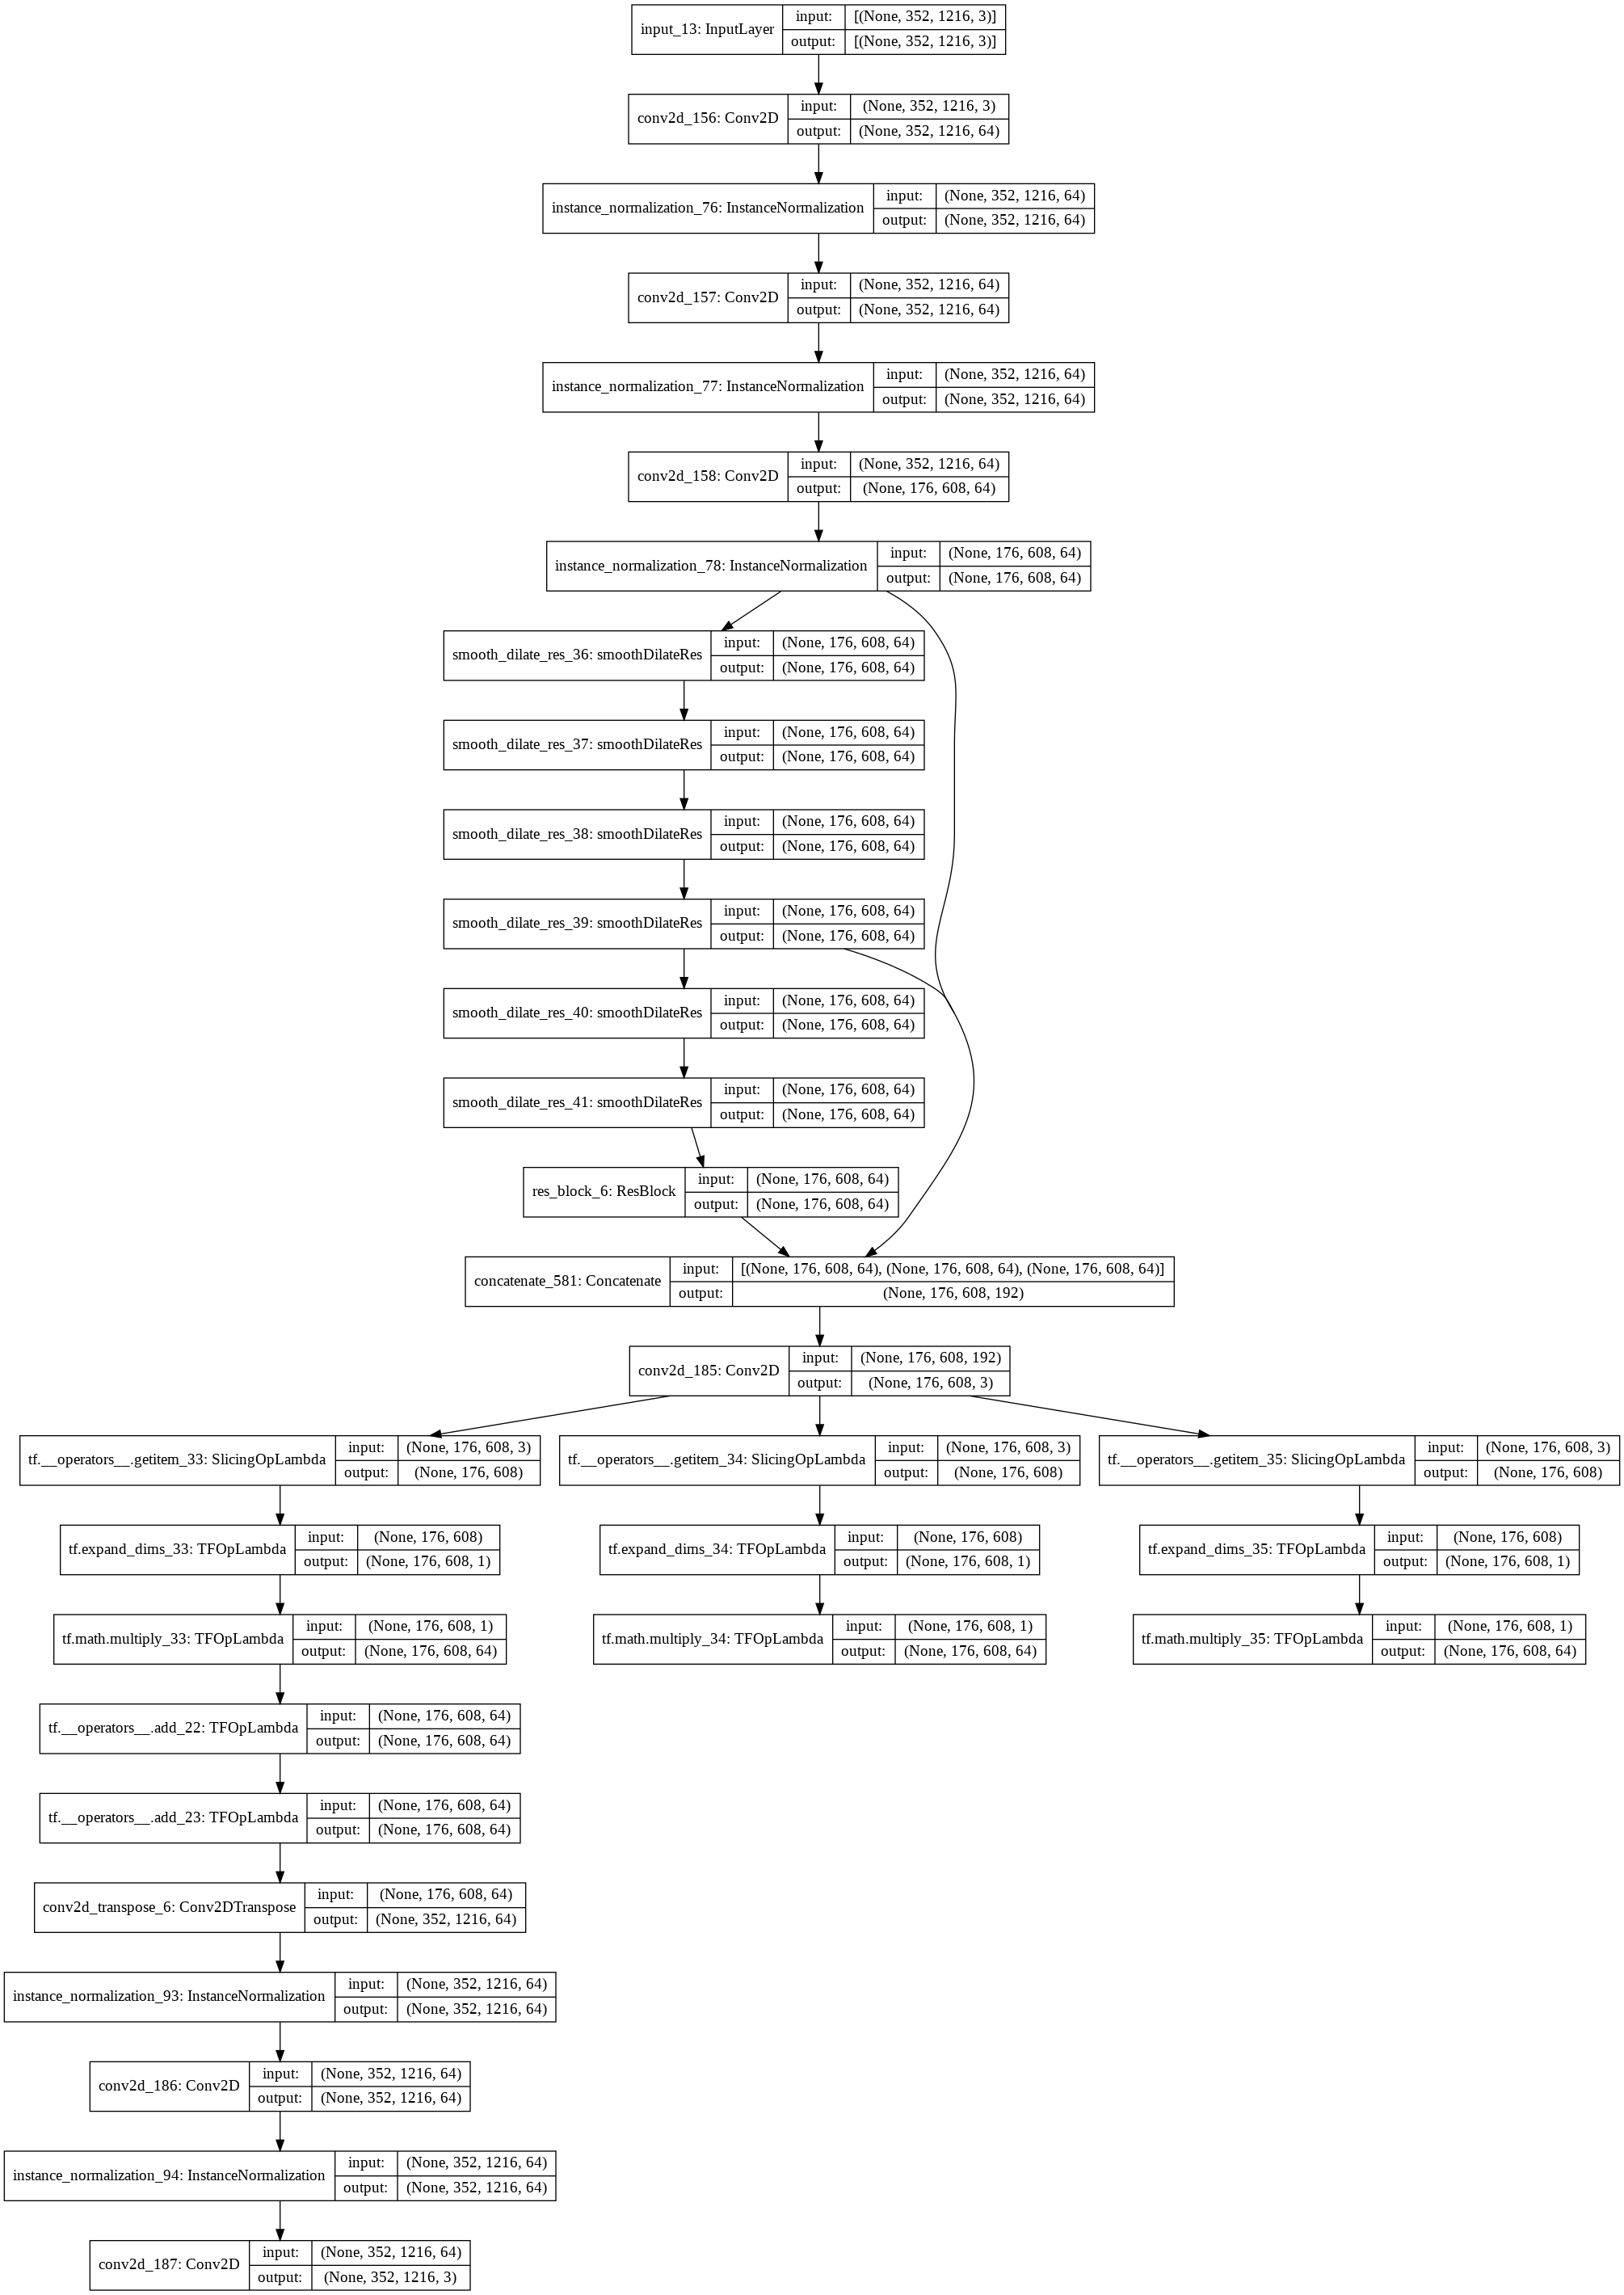

In [38]:


model = GCA()
model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=True                      # will show nested block
)



In [ ]:
model=tf.keras.models.load_model('/content/drive/MyDrive/kitti_nets/gca/')

In [41]:
# Hyperparameters
epochs = 10
batch_size = 1

train_data, val_data = dataset_preposses(orig_img_path = '/content/drive/MyDrive/kitti/gt', hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.1,seed_val=210)
train, val = dataloader(train_data, val_data, batch_size)

optimizer = Adam(learning_rate = 0.01)
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

540


In [42]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()
        
        # training loop
        
        
        for step, (train_batch_haze, train_batch_orig) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                loss=mean_squared_error(train_batch_orig, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            
            optimizer.apply_gradients(zip(grads, net.trainable_weights))

            train_loss_tracker.update_state(train_batch_orig, train_logits)
            if step == 0:
                print('[', end='')
            if step % 32 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        # validation loop
        
        for step, (val_batch_haze, val_batch_orig) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_loss_tracker.update_state(val_batch_orig, val_logits)
            
            if step % 32 ==0:
                display_img(net, val_batch_haze, val_batch_orig)
        
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        #net.save('trained_model')  
        #net.save_weights('/content/drive/MyDrive/nets/ffa/weights')         # save the model(variables, weights, etc)
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [ ]:
%%time
train_model(2, train, val,model, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [=

In [ ]:
model.save('/content/drive/MyDrive/kitti_nets/gca/')

model.save_weights('/content/drive/MyDrive/kitti_nets/gca/weights/')
InstanceNormalization()

INFO:tensorflow:Assets written to: /content/drive/MyDrive/kitti_nets/gman/assets


## evaluate

In [ ]:
import cv2
import matplotlib.pyplot as plt

def evaluate_gen(net):
    
    #test_img = glob.glob(test_img_path +'/*.jpg')
    test_img=glob.glob('/content/drive/MyDrive/test_set/hazy/*.png')
    #random.shuffle(test_img)
    i=0;
    for img in test_img:
        
        img = tf.io.read_file(img)
        img = tf.io.decode_png(img, channels = 3)
        
        img = tf.image.resize(img, size = (352,1216), antialias = True)
        
        img = img / 255.0
        print(i,end=" ")
        img = tf.expand_dims(img, axis = 0)      #transform input image from 3D to 4D ###
        
        dehaze = net(img)
        
        #plt.figure(figsize = (80, 80))
        
        #display_list = [img[0], dehaze[0]]       #make the first dimension zero
        im=dehaze[0]
        #im=((dehaze[0]-0.4)/0.2)*255
        #print(im.numpy().min())
        directory = '/content/drive/MyDrive/test_set/gca/'
        os.chdir(directory)
        filename = str(i) + '_outdoor_gen.png'
        #print(filename)
        #cv2.imwrite(filename,im) 
        #plt.imsave(filename,im)
        tf.keras.preprocessing.image.save_img(
    filename, im)

        os.chdir('/content')
        i+=1;
        

In [ ]:
evaluate_gen(model)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 